# Sun as a Star

AM suggested running parameters for the Sun through the MCMC recovery software to assess how accurate the parameter recovery is. One potential problem that we need to be concerned with is the limits of the model grid, which is valid for $0.08 \le M/M_{\odot} \le 1.00$. The Sun is therefore at the limits of the grid. Nevertheless, it will be a useful test for determining whether we are reliably recovering properties of stars with masses above the canonical threshold of $0.80 M_{\odot}$ for low-mass star work.

## Preliminaries

Before starting the trial, we must determine solar properties in a similar format to those measured using interferometry, namely bolometric flux and angular diameter. These values first require estimates of the solar luminosity and radius. We run into an issue about whether to adopt the solar properties that were used in the solar calibration runs for the models. While this may introduce a bias in the results, it only seems reasonable since they define relative values in the stellar evolution models. Instead of adopting uncertainties characteristic of true solar measurements, we'll adopt uncertainties characteristic of inteferometric data.

In [1]:
R_sun = [6.956e10, 6.956e8]  # cm, 1% uncertainty
L_sun = [3.846e33, 3.846e31] # erg s**-1, 1% uncertainty

In prinple, our results should be independent of the adopted distance for the Sun, since stellar models are more concerned with luminosity and radius. It's therefore also reasonable to test multiple distances. Initially, we'll adopt a value of $5.00 \pm 0.05$ pc. 

In [2]:
rad_in_mas = 206264.806e3
pc_in_cm = 3.08568e18

theta = [2.0*x*rad_in_mas/(5.0*pc_in_cm) for x in R_sun]  # mas, 1% uncertainty
F_bol = [x/(4.0*3.14159*(5.0*pc_in_cm)**2) for x in L_sun]  # erg s**-1 cm**-2, 1% uncertainty

print "\nAng. Dia.  = {:6.3f} +/-{:6.3f} mas\n".format(theta[0], theta[1])
print "Bol. Flux. = {:10.3e} +/-{:10.3e} erg s**-1 cm**-2".format(F_bol[0], F_bol[1])


Ang. Dia.  =  1.860 +/- 0.019 mas

Bol. Flux. =  1.286e-06 +/- 1.286e-08 erg s**-1 cm**-2


From which we may self-consistently calculate the effective temperature and associated uncertainty. Starting with the Stefan-Boltzmann equation for the luminosity of an object emitting as a blackbody,

\begin{equation}
    L = 4\pi\sigma R^2 T_{\rm eff}^4.
\end{equation}

Dividing both sides by $4\pi d^2$ (where $d$ is the object's distance), we arrive at

\begin{equation}
    \frac{L}{4\pi d^2} = \frac{4\pi\sigma R^2}{4\pi d^2} T_{\rm eff}^4,
\end{equation}

which simplifies to

\begin{equation}
    F_{\rm bol} = \frac{\sigma}{4}\theta^2 T_{\rm eff}^4,
\end{equation}

since $\theta \approx 2R / d$ under the small angle approximation. As a result, we can determine the effective temperature directly,

\begin{equation}
    T_{\rm eff} = \left(\frac{4 F_{\rm bol}}{\sigma \theta^2}\right)^{1/4},
\end{equation}

However, this equation is written assuming $\theta$ is radians, so we must add a conversion factor in our final equation, where $1 \textrm{ radian} = 206,265 \times 10^3 \textrm{ mas}$. We can therefore re-write the above equation such that

\begin{equation}
    T_{\rm eff} = 2.341\times10^5 \cdot \left(\frac{F_{\rm bol}}{\theta^2}\right)^{1/4},
\end{equation}

where $\theta$ is in milli-arcseconds and $F_{\rm bol}$ is expressed in erg s$^{-1}$ cm$^{-2}$.

In [3]:
stefan_boltzmann_sigma = 5.6704e-5  # cgs units

T_eff = [(4.0*F_bol[0]/(stefan_boltzmann_sigma*(theta[0]/rad_in_mas)**2))**0.25]
T_eff.append(T_eff[0]*((0.25*F_bol[1]/F_bol[0])**2 + (0.5*theta[1]/theta[0])**2 )**0.5)

print "\n Eff. Temp. = {:6.1f} +/- {:4.1f} K".format(T_eff[0], T_eff[1])


 Eff. Temp. = 5779.2 +/- 32.3 K


Sanity check shows that the derived effective temperature is equal to the value derived from the Stefan-Boltzmann equation prior to transforming the radius and luminosity to angular diameter and flux, resectively. 

---

## Parameter Inference

Parameter inference for the Sun is performed using the full setup, permitting mass, [M/H], age, $Y_i$, and $\alpha_{\rm MLT}$ to be fit. Uniform priors are adopted for all parameters, except the metallicity, for which we adopt [M/H] $= 0.00 \pm 0.05 \textrm{ dex}$. We use an ensemble sampler with 300 walkers that probe the parameter space over 600 interations.

---

## Results

Here, we'll work from the raw flattened chain from the MCMC inference. Start with importing standard packages for data handling and plotting.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Now we'll import the raw flattened chain from the ensemble of walkers and reform it into a series of the original chains and a flattened sample of the final 10 iterations to form the posterior probability distributions.

In [5]:
# preliminary: setup information about the run
f = 'data/Sun_W0300_N0600_B0000.dat'
N_walker = int(f[f.index('W') + 1:f.index('W') + 5])
N_steps  = int(f[f.index('N') + 1:f.index('N') + 5])

In [6]:
sun_flat_chain = np.genfromtxt(f)
sun_chains = sun_flat_chain.reshape(N_walker, -1, sun_flat_chain.shape[1])
sun_sample = sun_chains[:, -10:, :].reshape(-1, sun_flat_chain.shape[1])
sun_sample = np.array([row for row in sun_sample if row[0] > 0.08 and row[6] > 3.4])

Before we begin analyzing the posterior distributions, it's important to evaluate whether the MCMC chains appear to have converged, or if they are still settling down to a suitable solution. We can look at multiple diagnostics, but we'll begin by looking visually at the convergence of some of the parameters.

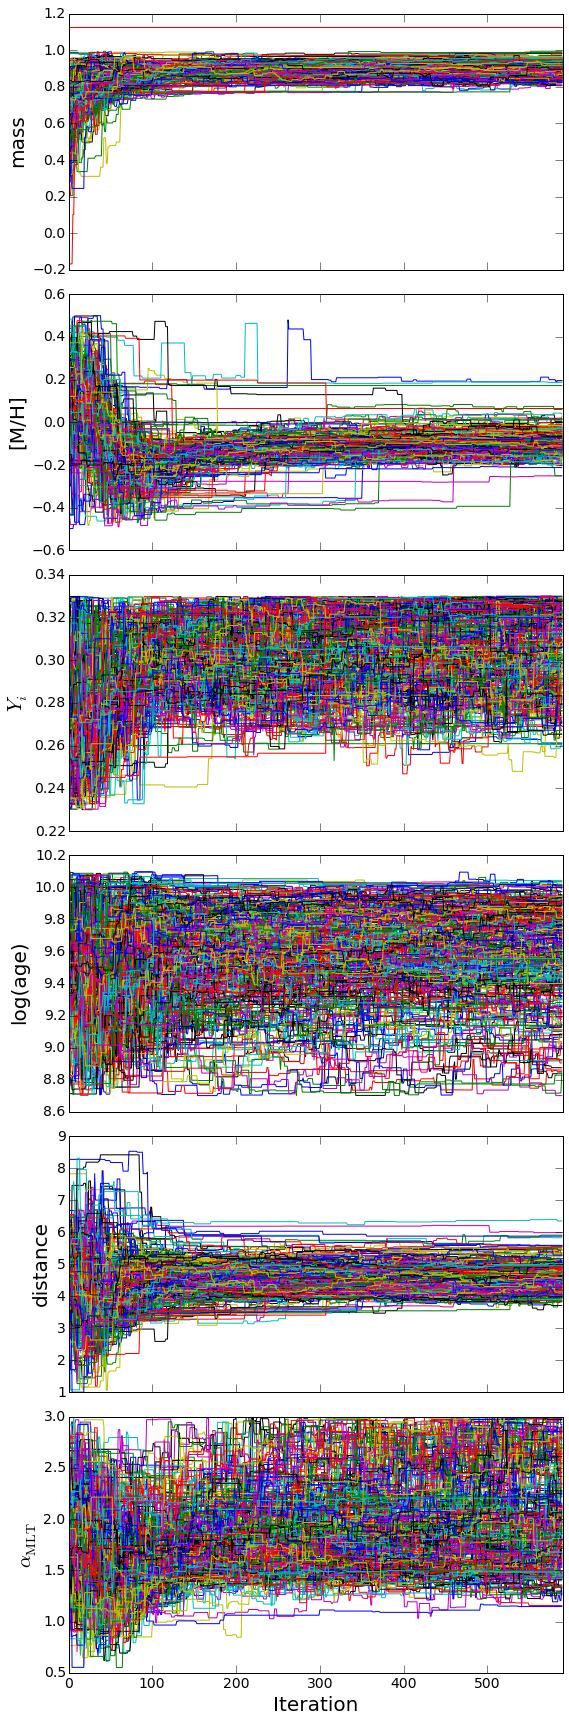

In [7]:
fig, ax = plt.subplots(6, 1, figsize=(8, 24), sharex=True)

# dictionary of parameters for easy reference
labels = {0: 'mass', 1: '[M/H]', 2: '$Y_i$', 3: 'log(age)', 4: 'distance', 5: '$\\alpha_{\\rm MLT}$'}

# look at only first size parameters
for par in range(6):
    for walker in range(sun_chains.shape[0]):
        ax[par].plot(sun_chains[walker, :, par], '-', lw=1)
    ax[par].set_ylabel(labels[par], fontsize=20.)
    ax[par].set_xlim(0, sun_chains.shape[1])
    ax[par].tick_params(which='major', axis='both', length=8., labelsize=14.)
ax[-1].set_xlabel('Iteration', fontsize=20.)

fig.tight_layout()

With the Markov chains converging on an accurate representation of the posterior distributions, we can plot the posteriors from samples taken over the last 10 iterations (3000 samples).

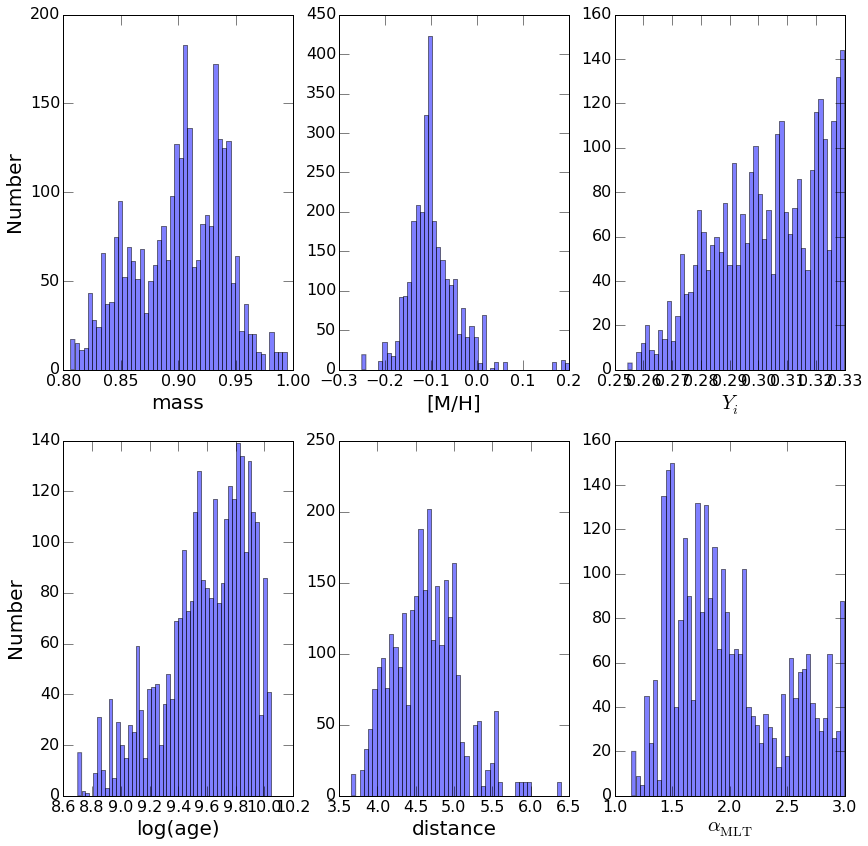

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(14, 14))

ax[0, 0].set_ylabel('Number', fontsize=20.)
ax[1, 0].set_ylabel('Number', fontsize=20.)
for par in range(3):
    ax[0, par].set_xlabel(labels[par], fontsize=20.)
    ax[0, par].tick_params(which='major', axis='both', length=10.0, labelsize=16.0)
    hist_data = ax[0, par].hist(sun_sample[:, par], bins=50, color='blue', alpha=0.5)
for par in range(3, 6):
    ax[1, par-3].set_xlabel(labels[par], fontsize=20.)
    ax[1, par-3].tick_params(which='major', axis='both', length=10.0, labelsize=16.0)
    hist_data = ax[1, par-3].hist(sun_sample[:, par], bins=50, color='blue', alpha=0.5)

[Full analysis pending.]

Looking at the mean and median values for all parameters,

In [11]:
sun_medians = np.median(sun_sample, axis=0)
sun_means = np.mean(sun_sample, axis=0)
sun_lower = np.percentile(sun_sample, 16.0, axis=0)
sun_upper = np.percentile(sun_sample, 84.0, axis=0)

print '\n', sun_medians, '\n'
print sun_lower, '\n'
print sun_means, '\n'
print sun_upper, '\n'


[ 0.90518365 -0.10356941  0.3056898   9.64167346  4.61450075  1.88047447
  3.76125608 -5.89019911  1.86020091] 

[ 0.85338295 -0.14057627  0.28222858  9.26489359  4.15891819  1.4866531
  3.75845129 -5.89493685  1.84260049] 

[ 0.90031605 -0.09613176  0.30328154  9.59168509  4.629717    1.99199042
  3.76102138 -5.89183274  1.8600163 ] 

[ 0.94059627 -0.04883458  0.3233493   9.89270993  5.0027443   2.61542979
  3.76445783 -5.88533529  1.88113453] 



Somehow, the code managed to recover the mixing length values with relative precision. Although the posterior is quite messy. The models predict a considerably lower mass, but this is almost certainly a consequence of the fact that the model grid cuts off at $1.0 M_{\odot}$, with some sub-regions of the grid terminating around $0.95 M_{\odot}$. Therefore, the grid is forced to accomodate for the grid's upper limit by lower the metallicity and increasing the helium abundance to raise the effective temperature of the model.